In [1]:
import numpy as np
import pandas as pd
import os

from utils import preprocessing
from models.features_extractor import CustomCNN
from envs.trading_env import SimpleTradingEnv
from envs.base import BaseTradingEnv

from stable_baselines3 import DQN, PPO, A2C
# from sb3_contrib import QRDQN
from stable_baselines3.common.env_checker import check_env


Loading BokehJS ...

In [2]:
window_size = 20
fee = 0.000665

In [3]:
class TradingEnv(BaseTradingEnv):
    def _calculate_reward(self):
        reward = 0.0
        # reward = self.position.profit_or_loss_pct - self.prev_profit_or_loss_pct
        if self.closed_trades.empty:
            return reward

        trade = self.closed_trades.iloc[-1, :]
        return reward if trade["ExitTime"] != self.current_datetime else trade["ReturnPct"]

In [4]:
# def preprocessing(candles):
#     df = pd.DataFrame()
#     price = candles["Close"]
#     df["diff_price_pct"] = price.pct_change(1)
#     df = df.fillna(0)
#     print(df.head())
#     return df

In [5]:
df = pd.read_csv("./data/3600/ethusd/2021-01-01.csv", parse_dates=[0]).set_index("Date")
train_df = df[: len(df) // 2]
eval_df = df[len(df) // 2 :]
train_env = TradingEnv(train_df, preprocessing(df), window_size=window_size, fee=fee)
eval_env = TradingEnv(eval_df, preprocessing(df), window_size=window_size, fee=fee)
check_env(train_env)

In [6]:
# policy_kwargs = dict(
#     features_extractor_class=CustomCNN,
#     features_extractor_kwargs=dict(features_dim=32),
# )
# model = PPO("CnnPolicy", train_env, verbose=0, tensorboard_log="./logs", policy_kwargs=policy_kwargs)
# model = PPO("MlpPolicy", train_env, verbose=1, tensorboard_log="./logs")
model_class = PPO
model = model_class("MlpPolicy", train_env, verbose=1, tensorboard_log="./logs").learn(100000)
model_name = model_class.__class__.__name__
model.save(f"./results/{model_name}")
del model

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs\QRDQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14e+03 |
|    ep_rew_mean      | -0.181   |
|    exploration rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 971      |
|    time_elapsed     | 8        |
|    total timesteps  | 8560     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14e+03 |
|    ep_rew_mean      | -0.124   |
|    exploration rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 973      |
|    time_elapsed     | 17       |
|    total timesteps  | 17120    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14e+03 |
|   

In [7]:
model = model_class.load(f"./results/{model_name}")
print(model)

(20, 11)


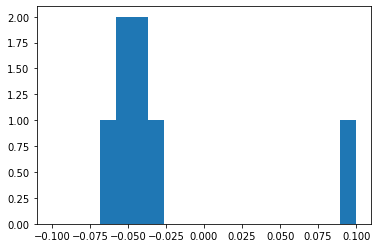

In [8]:
import matplotlib.pyplot as plt
def evaluate(model, env, render=True) -> np.ndarray:
    state = env.reset()
    print(state.shape)
    done = False

    episode_rewards = []

    while not done:
        action, state = model.predict(state)
        state, reward, done, info = env.step(action)

        if render:
            env.render()

        episode_rewards.append(reward)

        if done:
            break

    return np.array(episode_rewards)


episode_rewards = evaluate(model, eval_env, render=False)
episode_rewards = episode_rewards[~(episode_rewards == 0)]
fig, axs = plt.subplots(1, 1)
bins = np.linspace(-0.1, 0.1, 20)
n, bins, patches = axs.hist(episode_rewards, bins=bins)

In [9]:
from utils import backtest

In [10]:
# train_env.reset()
# eval_env.reset()
stats_train = backtest(model, train_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-train")
stats_eval = backtest(model, eval_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-eval")

stats = pd.DataFrame()
stats["train"] = stats_train
stats["eval"] = stats_eval
# stats = stats.drop(["Best Trade [%]", "Worst Trade [%]", "_strategy", "_equity_curve", "_trades"], axis=0)
print(stats)

                                                                    train  \
Start                                                 2021-01-01 00:00:00   
End                                                   2021-03-31 23:00:00   
Duration                                                 89 days 23:00:00   
Exposure Time [%]                                               99.027778   
Equity Final [$]                                            266429.807171   
Equity Peak [$]                                            1022826.884186   
Return [%]                                                     -73.357019   
Buy & Hold Return [%]                                          149.948745   
Return (Ann.) [%]                                               -99.52265   
Volatility (Ann.) [%]                                         1026.885505   
Sharpe Ratio                                                          0.0   
Sortino Ratio                                                         0.0   

In [11]:
stats.loc["_strategy", "train"].env.closed_trades

,Size,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime
0,-1354,738.078851,1105.1,-496946.635814,-0.497266,2021-01-01 20:00:00,2021-01-13 02:00:00
1,-450,1116.057328,1251.3,-60859.202400,-0.121179,2021-01-13 03:00:00,2021-01-17 11:00:00
2,-355,1244.671742,1372.8,-45485.531413,-0.102941,2021-01-17 12:00:00,2021-01-31 01:00:00
3,-292,1357.796464,1748.4,-114056.232366,-0.287675,2021-01-31 02:00:00,2021-02-11 08:00:00
4,-162,1740.641703,1897.3,-25378.644114,-0.090000,2021-02-11 09:00:00,2021-02-18 16:00:00
5,-135,1897.537298,1712.0,25047.535230,0.097778,2021-02-18 17:00:00,2021-03-08 22:00:00
6,-162,1735.145360,1774.8,-6424.051599,-0.022854,2021-03-08 23:00:00,2021-03-13 02:00:00
7,-156,1763.326607,1779.7,-2554.249230,-0.009286,2021-03-13 03:00:00,2021-03-23 00:00:00
8,-153,1778.016832,1693.6,12915.775296,0.047478,2021-03-23 01:00:00,2021-03-27 18:00:00
9,-168,1697.370498,1828.7,-22063.356420,-0.077372,2021-03-27 19:00:00,2021-03-31 23:00:00


In [12]:
stats.loc["_trades", "train"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1354,20,290,738.078851,1105.1,-496946.635814,-0.497266,2021-01-01 20:00:00,2021-01-13 02:00:00,11 days 06:00:00
1,-450,291,395,1116.057328,1251.3,-60859.202400,-0.121179,2021-01-13 03:00:00,2021-01-17 11:00:00,4 days 08:00:00
2,-355,396,721,1244.671742,1372.8,-45485.531413,-0.102941,2021-01-17 12:00:00,2021-01-31 01:00:00,13 days 13:00:00
3,-292,722,992,1357.796464,1748.4,-114056.232366,-0.287675,2021-01-31 02:00:00,2021-02-11 08:00:00,11 days 06:00:00
4,-162,993,1168,1740.641703,1897.3,-25378.644114,-0.090000,2021-02-11 09:00:00,2021-02-18 16:00:00,7 days 07:00:00
5,-135,1169,1606,1897.537298,1712.0,25047.535230,0.097778,2021-02-18 17:00:00,2021-03-08 22:00:00,18 days 05:00:00
6,-162,1607,1706,1735.145360,1774.8,-6424.051599,-0.022854,2021-03-08 23:00:00,2021-03-13 02:00:00,4 days 03:00:00
7,-156,1707,1944,1763.326607,1779.7,-2554.249230,-0.009286,2021-03-13 03:00:00,2021-03-23 00:00:00,9 days 21:00:00
8,-153,1945,2058,1778.016832,1693.6,12915.775296,0.047478,2021-03-23 01:00:00,2021-03-27 18:00:00,4 days 17:00:00
9,-168,2059,2158,1697.370498,1815.4,-19828.956420,-0.069537,2021-03-27 19:00:00,2021-03-31 22:00:00,4 days 03:00:00
